In [1]:
import sys
import os
from subprocess import run

def r(cmd: str):
    if os.environ.get('TERM').startswith('xterm'):
        print(f'\x1b[31m$ {cmd}\x1b[0m', flush=True, file=os.sys.stderr)
    else:
        print(f'$ {cmd}', flush=True, file=os.sys.stderr)

    return run(cmd, shell=True, check=True)


def setup_colab():
    r('git clone https://github.com/UlisseMini/procgen-tools')
    os.chdir('procgen-tools')
    r('pip install -e .')
    r('pip install -r requirements.txt || true') # fails due to a warning sometimes
    r('mkdir -p data/vfields figures trained_models/maze_I')
    r('wget https://nerdsniper.net/mats/episode_data.tgz && tar -xzf episode_data.tgz')
    r('wget https://nerdsniper.net/mats/data.tgz && tar -xzf data.tgz')
    r('wget https://nerdsniper.net/mats/model_rand_region_5.pth -O trained_models/maze_I/model_rand_region_5.pth')
    os.chdir('experiments')


if 'google.colab' in sys.modules:
    if os.path.exists('procgen-tools'):
        os.chdir('procgen-tools/experiments')
    elif 'procgen-tools' not in os.getcwd():
        setup_colab()

## Model editing: Finding a "cheese" vector

The basic idea is simple, in a maze with no cheese the cheese-decision-influence won't be active and the mouse will try and go to the top-right. In a maze with cheese, *both* the top-right and cheese decision-influences will be active.

What if we record the activations for both on a specific layer $l$, and patch the network by adding the difference?

Formally, pick a maze $m$ and layer $l$. Let $a_c \in \mathbf{R}^n$ denote the activations of layer $l$ on maze $m$ *with the cheese*, and $a_{\neg c} \in \mathbf{R}^n$ denote the activations where the cheese is first removed from the maze. (In both of these cases, the mouse remains in the start position)

Now we patch the network, setting the output of layer $l$ ($a_l$) to be $a_l' = a_l + \alpha(a_c - a_{\neg c})$ for varying choices of $\alpha$.

For the first step we have $a_l = a_c$ (mouse hasn't moved, cheese exists) giving $a_l' = (1+\alpha)a_c - \alpha a_{\neg c}$, and for $\alpha = -1$ we have $a_l' = a_{\neg c}$ meaning ignore the cheese.

Does this work beyond the first timestep? Surprisingly, yes. It raises the probability we go to the top right a large amount when we reach "forks in the road" (decision squares in our terminology) and lowers the probability we go to the cheese.

(This doesn't prove we're doing something motivational. We could be doing something perceptual, like editing out the knowledge of the cheese the mouse has.)

### Interactively explore the effect of the cheese vector

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from glob import glob
from collections import defaultdict

In [3]:
vfields = [pickle.load(open(f, 'rb')) for f in glob('../data/vfields/seed-*.pkl')]
vfields_by_level = defaultdict(list)
for vf in vfields:
    vfields_by_level[vf['seed']].append(vf)

def get_vfields(seed: int, coeff: float):
    return next(vf for vf in vfields_by_level[seed] if vf['coeff'] == coeff)

In [4]:
from ipywidgets import interact, IntSlider, FloatSlider
import vfield_stats as vs

def _coeffs_for(seed: int):
    return sorted(set(vf['coeff'] for vf in vfields_by_level[seed]))

seed_max = max(vf['seed'] for vf in vfields)
min_coeff, max_coeff = min(vf['coeff'] for vf in vfields), max(vf['coeff'] for vf in vfields)

@interact(seed = IntSlider(min=0, max=seed_max, step=1, value=0), coeff = FloatSlider(min=min_coeff, max=max_coeff, step=0.1, value=1.0))
def interact_vfields(seed: int, coeff: float):
    # set coeff to nearest available in vfields_by_level[seed]
    coeff = min(_coeffs_for(seed), key=lambda x: abs(x - coeff))
    vfs = get_vfields(seed, coeff)
    vs.plot_vfs(vfs)

interactive(children=(IntSlider(value=0, description='seed', max=99), FloatSlider(value=1.0, description='coef…

### Behavioral statistics after patching

To see the statistical change in propensity to go to the cheese, we can look at the probability of going to the cheese at the decision square, vs. the probability of going to the top right.

**Note**: We're *subtracting* the cheese vector, so the probability of going to the cheese should be lower, and the probability of going to the top right (or towards neither) should be higher.

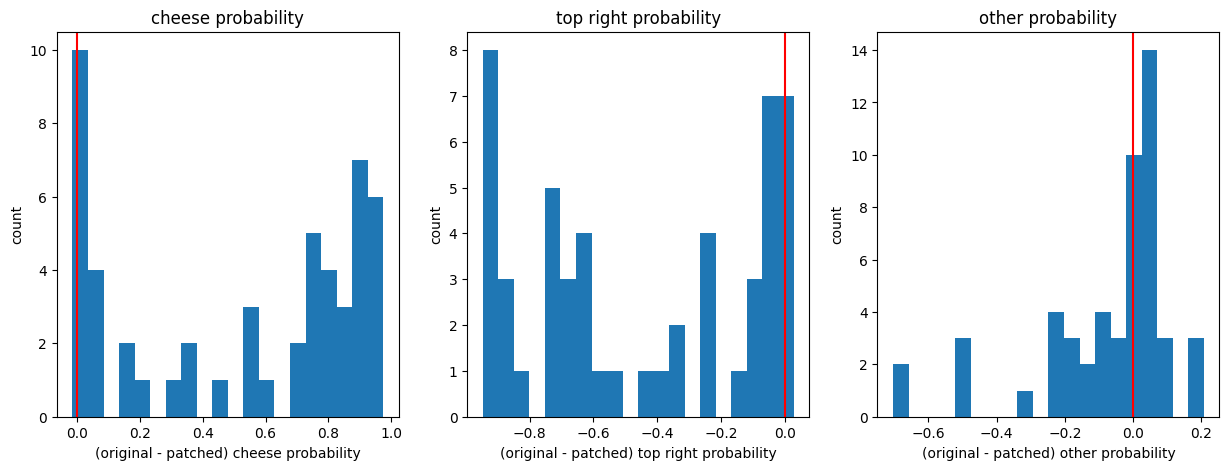

In [5]:
dprobs_patched, dprobs_original = vs.get_decision_probs_patched_and_original(vfields, coeff=-1.0)
vs.plot_decision_probs(dprobs_patched, dprobs_original)
plt.show()